In [1]:
%matplotlib inline

# Importing modules

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.poly import create_vertice
import re
from datetime import datetime, timedelta

from matplotlib.animation import FuncAnimation
from numpy import arange, isnan, meshgrid, ones

from py_eddy_tracker import start_logger
from py_eddy_tracker.data import get_demo_path
from py_eddy_tracker.dataset.grid import GridCollection, _fit_circle_path
from py_eddy_tracker.observations.observation  import EddiesObservations
from py_eddy_tracker.gui import GUI_AXES
from py_eddy_tracker.generic import uniform_resample, coordinates_to_local
from py_eddy_tracker.poly import create_vertice, poly_area, visvalingam

from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.cm as cm

from typing import List, Tuple

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from py_eddy_tracker.eddy_feature import Amplitude, Contours, detect_local_minima_
import time
from os import walk
from datetime import datetime

# Necessary Classes and function definitions

In [3]:
class eddy_detection():
    def __init__(self, dataset_path: str, lat: list, lon: list, height: str):
        self.path = dataset_path
        self.height = height
        self.data: List[Tuple] = self.load_data()
        self.hours_since_start_list: list = []
        self.grid_list: List[RegularGridDataset] = []
        self.days_list: list = [] 
        self.lat: list = lat
        self.lon: list = lon
        self.anticyclonic_list: list = []
        self.cyclonic_list: list = []
        return None
    
    def start_axes(self, title):
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
        ax.set_xlim(self.lon[0], self.lon[1]), ax.set_ylim(self.lat[0], self.lat[1])
        ax.set_aspect("equal")
        ax.set_title(title, weight="bold")
        return ax


    def update_axes(self, ax, mappable=None):
        ax.grid()
        if mappable:
            plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

    def load_data(self):
        grid_collection = GridCollection.from_netcdf_cube(
            self.path,
            "LONGITUDE",
            "LATITUDE",
            "TIME",
            heigth=self.height)
        return grid_collection.datasets
    
    def create_list_dataset(self, days_list: List, bessel: bool = True):
        self.days_list = days_list
        for day in self.days_list:
            hours, g = self.data[day-1]
            g.vars[self.height] = np.ma.array(g.vars[self.height], mask=np.isnan(g.vars['ssh']))
            #g.add_uv(self.height)
            if bessel:
                g.bessel_high_filter(self.height, 500) 
            self.hours_since_start_list.append(hours)
            self.grid_list.append(g)

    def plot_graph(self, days:list):
        for day in days:
            ax = self.start_axes("SSH (m)")
            m = self.grid_list[day-1].display(ax, self.height, vmin=-1, vmax=1, cmap="RdBu_r")
            self.update_axes(ax, m)
        return None
    def detect_eddies(self, min_pixel : int = 30):
        for day in self.days_list:
            date = datetime(1950, 1 , 1) + timedelta(hours=int(self.hours_since_start_list[day-1])) 
            a, c = self.grid_list[day-1].eddy_identification(self.height, "u", "v", date, 0.002, pixel_limit=(min_pixel, 2000), shape_error=70)
            self.anticyclonic_list.append(a)
            self.cyclonic_list.append(c)
        return None
    def plot_detected(self, days:list):
        for day in days:
            ax = self.start_axes("Detected Eddies")
            self.anticyclonic_list[day - 1].display(
                ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70
            )
            self.cyclonic_list[day - 1].display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
            ax.legend()
            self.update_axes(ax)
        return None

In [4]:
def all_pixels_below_h0_modified(amp, level):
    """
    Check CSS11 criterion 1: The SSH values of all of the pixels
    are below a given SSH threshold for cyclonic eddies.
    """
    # In some cases pixel value may be very close to the contour bounds
    # All local extrema index on th box
    lmi_i, lmi_j = detect_local_minima_(
        amp.grid_extract.data,
        amp.grid_extract.mask,
        amp.pixel_mask,
        amp.mle,
        1,
    )
    # After we use grid.data because index are in contour and we check before than no pixel are hide
    nb = len(lmi_i)
    if nb == 0:
        print("No extrema found in contour of %d pixels in level %f")
        return False
    elif nb == 1:
        i, j = lmi_i[0], lmi_j[0]
    else:
        # Verify if several extrema are seriously below contour
        nb_real_extrema = (
            (level - amp.grid_extract.data[lmi_i, lmi_j])
            >= amp.interval_min_secondary
        ).sum()
        if nb_real_extrema > amp.mle:
            return False
        index = amp.grid_extract.data[lmi_i, lmi_j].argmin()
        i, j = lmi_i[index], lmi_j[index]
    amp.amplitude = abs(amp.grid_extract.data[i, j] - amp.h_0)
    (x_start, _), (y_start, _) = amp.contour.bbox_slice
    i += x_start
    j += y_start
    return i, j

In [5]:
def all_pixels_above_h0_modified(amp, level):
    """
    Check CSS11 criterion 1: The SSH values of all of the pixels
    are above a given SSH threshold for anticyclonic eddies.
    """
    # All local extrema index on th box
    lmi_i, lmi_j = detect_local_minima_(
        amp.grid_extract.data,
        amp.grid_extract.mask,
        amp.pixel_mask,
        amp.mle,
        -1,
    )
    # After we use grid.data because index are in contour and we check before than no pixel are hide
    nb = len(lmi_i)
    if nb == 0:
        print("No extrema found in contour of %d pixels in level %f")
        return False
    elif nb == 1:
        i, j = lmi_i[0], lmi_j[0]
    else:
        # Verify if several extrema are seriously above contour
        nb_real_extrema = (
            (amp.grid_extract.data[lmi_i, lmi_j] - level)
            >= amp.interval_min_secondary
        ).sum()
        if nb_real_extrema > amp.mle:
            return False
        index = amp.grid_extract.data[lmi_i, lmi_j].argmax()
        i, j = lmi_i[index], lmi_j[index]
    amp.amplitude = abs(amp.grid_extract.data[i, j] - amp.h_0)
    (x_start, _), (y_start, _) = amp.contour.bbox_slice
    i += x_start
    j += y_start
    return i, j

In [6]:
def get_amplitude_modified(
        contour, contour_height, data, anticyclonic_search=True, level=None, **kwargs
    ):
        # Instantiate Amplitude object
        amp = Amplitude(
            # Indices of all pixels in contour
            contour=contour,
            # Height of level
            contour_height=contour_height,
            # All grid
            data=data,
            **kwargs,
        )
        if anticyclonic_search:
            reset_centroid = all_pixels_above_h0_modified(amp, level)
        else:
            reset_centroid = all_pixels_below_h0_modified(amp, level)
        return reset_centroid, amp

In [7]:
def eddy_obs(ssh_class_object, day, seg_data):
    anti_seg_data = seg_data.copy()
    anti_seg_data[anti_seg_data == 1] = 0
    cyc_seg_data = seg_data.copy()
    cyc_seg_data[cyc_seg_data == 2] = 0
    
    regular_grid = ssh_class_object.grid_list[day-1]
    x, y = regular_grid.x_c, regular_grid.y_c
    coord_dict = {}
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            coord_dict[(xi,yi)] = (i,j)
    xx,yy = np.meshgrid(x,y)
    ssh_data = regular_grid.grid("ssh")
    
    a_and_c = list()

    i_x_in = None
    i_y_in = None
    iterator = 1
    index_x = None
    index_y = None
    
    array_variables = [
        "contour_lon_e",
        "contour_lat_e",
        "contour_lon_s",
        "contour_lat_s",
        "uavg_profile",
    ]

    track_extra_variables = [
        "height_max_speed_contour",
        "height_external_contour",
        "height_inner_contour",
        "lon_max",
        "lat_max",
    ]

    out_sampling = dict(fixed_size=50)
    resample = visvalingam

    pixel_limit = (15, 1000)
    regular_grid.init_speed_coef("u", "v")


    for anticyclonic_search in [True, False]:
        eddies = []
        coll_idx = 1
        if anticyclonic_search:
            contours = Contours(xx, yy, anti_seg_data.T, (0, 2))
        else:
            contours = Contours(xx, yy, cyc_seg_data.T, (0, 1))

        segments = contours.contours.allsegs
        coll = contours.contours.collections[0]
        contour_paths = coll.get_paths()

        nb_paths = len(contour_paths)


        
        #t0 = time.time()
        k = 0
        if contour_paths:
            for contour in contour_paths:
                index_matrix = np.zeros([1,2], dtype=int)
                
                if contour.used:
                    continue
                    
                
                #np.where(xx == contour.vertices[:,0])[0]
                """
                xx
                [2, 3, 4]
                [2, 3, 4]
                [2, 3, 4]
                
                yy
                [5, 5, 5]
                [6, 6, 6]
                [7, 7, 7]
                
                
                contour.vertices[:,0] = [1,2]
                contour.vertices[:,1] = [5,6]
                
                
                [t, f, f]
                [t, f, f]
                [t, f, f]
                and
                [t, t, t]
                [t, t, t]
                [f, f, f]
                
                we obtain:
                
                [t, f, f]
                [t, f, f]
                [f, f, f]
                
                we want:
                
                [f, f, f]
                [t, f, f]
                [f, f, f]
                
                qww = np.array([xx, yy])
                bool_vert = np.isin(qww, contour.vertices)
                print(xx)
                print(yy)
                print(sum(sum(bool_vert)))
                ssh_data1 = ssh_data.T[bool_vert]
                print(bool_vert.shape)
                print(ssh_data1.shape)
                print(ssh_data1.mean())
                
                
                """
                
                ssh_values_on_contour = np.array([ssh_data[coord_dict[tuple(i)]] for i in contour.vertices])
                avg_ssh = ssh_values_on_contour.mean()
                
#                 print(avg_ssh)
                
                
#                 for i in contour.vertices:
#                     coord_idx = np.argwhere((xx==i[0]) & (yy==i[1]))[0]
#                     index_matrix = np.vstack((index_matrix, coord_idx))
                

#                 index_matrix = index_matrix[1:, :] #Leaving the zeroes which were created during np.zeros
#                 chopped_array = ssh_data.T[tuple(map(tuple, index_matrix.T))]
#                 avg_ssh = chopped_array.mean()
                
#                 print(avg_ssh)

            
                
                
                
                i_x_in, i_y_in = contour.pixels_in(regular_grid)
                (x_start, x_stop), (y_start, y_stop) = contour.bbox_slice

                reset_centroid, amp = get_amplitude_modified(contour = contour, contour_height = avg_ssh, anticyclonic_search=anticyclonic_search, data = regular_grid.vars['ssh'], level = avg_ssh, interval = 2)
                
                if (amp.amplitude == 0):
                    continue
                

                if reset_centroid:
                    centi = reset_centroid[0]
                    centj = reset_centroid[1]
                    # To move in regular and unregular grid
                    if len(x.shape) == 1:
                        centlon_e = regular_grid.x_c[centi]
                        centlat_e = regular_grid.y_c[centj]
                    else:
                        centlon_e = regular_grid.x_c[centi, centj]
                        centlat_e = regular_grid.y_c[centi, centj]
                (
                    max_average_speed,
                    speed_contour,
                    inner_contour,
                    speed_array,
                    i_max_speed,
                    i_inner,
                ) = regular_grid.get_uavg(
                    contours,
                    centlon_e,
                    centlat_e,
                    contour,
                    anticyclonic_search,
                    coll_idx,
                    pixel_min=pixel_limit[0],
                )
                obs = EddiesObservations(
                    size=1,
                    track_extra_variables=track_extra_variables,
                    track_array_variables=50,
                    array_variables=array_variables,
                )
                obs.height_max_speed_contour[:] = avg_ssh
                obs.height_external_contour[:] = avg_ssh
                obs.height_inner_contour[:] = avg_ssh
                array_size = speed_array.shape[0]
                obs.nb_contour_selected[:] = array_size
                obs.uavg_profile[:] = speed_array[0]
                obs.amplitude[:] = amp.amplitude
                obs.speed_average[:] = max_average_speed
                obs.num_point_e[:] = contour.lon.shape[0]
                obs.num_point_s[:] = speed_contour.lon.shape[0]


                xy_i = uniform_resample(
                    inner_contour.lon,
                    inner_contour.lat,
                    num_fac=10,
                )
                xy_e = uniform_resample(
                    contour.lon, contour.lat, num_fac=10,
                )
                xy_s = uniform_resample(
                    speed_contour.lon,
                    speed_contour.lat,
                    num_fac=10,
                )


                # First, get position of max SSH based on best fit circle with resampled innermost contour
                centlon_i, centlat_i, _, _ = _fit_circle_path(create_vertice(*xy_i))
                obs.lon_max[:] = centlon_i
                obs.lat_max[:] = centlat_i

                # Second, get speed-based radius, shape error, eddy center, area based on resampled contour of max uavg
                centlon_s, centlat_s, eddy_radius_s, aerr_s = _fit_circle_path(
                    create_vertice(*xy_s)
                )
                obs.radius_s[:] = eddy_radius_s
                obs.shape_error_s[:] = aerr_s
                obs.speed_area[:] = poly_area(
                    *coordinates_to_local(*xy_s, lon0=centlon_s, lat0=centlat_s)
                )
                obs.lon[:] = centlon_s
                obs.lat[:] = centlat_s

                # Third, compute effective radius, shape error, area from resampled effective contour
                _, _, eddy_radius_e, aerr_e = _fit_circle_path(
                    create_vertice(*xy_e)
                )
                obs.radius_e[:] = eddy_radius_e
                obs.shape_error_e[:] = aerr_e
                obs.effective_area[:] = poly_area(
                    *coordinates_to_local(*xy_e, lon0=centlon_s, lat0=centlat_s)
                )

                # Finally, resample contours with output parameters
                xy_e_f = resample(*xy_e, **out_sampling)
                xy_s_f = resample(*xy_s, **out_sampling)
                obs.contour_lon_s[:], obs.contour_lat_s[:] = xy_s_f
                obs.contour_lon_e[:], obs.contour_lat_e[:] = xy_e_f
                eddies.append(obs)
                # To reserve definit ively the area
                #ssh_data.mask[i_x_in, i_y_in] = True
                
        
        #t1 = time.time()

        if len(eddies) == 0:
            eddies = EddiesObservations(
                track_extra_variables=track_extra_variables,
                track_array_variables=1,
                array_variables=array_variables,
            )
        else:
            eddies = EddiesObservations.concatenate(eddies)
        eddies.sign_type = 1 if anticyclonic_search else -1
        eddies.time[:] = int((timedelta(hours=int(ssh_class_object.hours_since_start_list[day-1]))).total_seconds() / 86400.0) #Check this out; produce whole number day
        
        eddies.lon_max[:] %= 360
        eddies.lon[:] %= 360
        ref = eddies.lon - 180
        eddies.contour_lon_e[:] = ((eddies.contour_lon_e.T - ref) % 360 + ref).T
        eddies.contour_lon_s[:] = ((eddies.contour_lon_s.T - ref) % 360 + ref).T
        a_and_c.append(eddies)
        
    return a_and_c
            

   

In [8]:
# #Time fix for SSH using SEG data
# days_dict = {0:0, 1:31, 2:59 ,3:90, 4:120, 5:151, 6:181, 7:212, 8:243, 9:273, 10:304, 11:334, 12:365}
# for j in range(1, 4): #years
#     for i in range(1, 13): #months
#         data_addr_nn = "/home/ollie/ssunar/ssh_filtered/ssh_gridded_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         seg_data_addr_nn = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         time = None
#         with Dataset(data_addr_nn, "a") as true_ds:
#             with Dataset(seg_data_addr_nn, "r") as seg_ds:
#                 time = seg_ds['TIME'][:]
#             true_ds['TIME'][:] = time
#             #true_ds['TIME'][:] += days_dict[i-1] * 24


# End of the functions and Classes declarations

In [9]:
# Prev Version
# loaded_arr = np.loadtxt("/home/ollie/ssunar/pred_data.out")
# load_original_arr = loaded_arr.reshape(
#     loaded_arr.shape[0], loaded_arr.shape[1] // 480, 480)
# start = 0

# Getting Prediction data in single day format.

In [10]:
pred_seg_data_np = np.load("/home/ollie/ssunar/pred_data.npy")
    

In [11]:
file_a_pred_list = []
file_c_pred_list = []
file_a_true_alg_list = []
file_c_true_alg_list = []
start = 365 + 365
for kk in range(3, 4):
    for i in range(1, 13):
        data_addr_nn = '/home/ollie/ssunar/nn_interpolation_new/ssh_gridded_196'+str(kk)+'_001_'+str(i).zfill(2)+'_new.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        ssh_class_object = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon, height = "ssh")
        ssh_class_object.create_list_dataset(days)


        print("last day", last_day)

        true_seg_data_addr = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_196"+str(kk)+'_001_'+str(i).zfill(2)+"_new.nc"
        true_ds = xr.open_dataset(true_seg_data_addr)
        true_seg_data_month = true_ds.seg_mask.values
        print("true seg shape", true_seg_data_month.shape)

        for j in range(last_day):
            a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=true_seg_data_month[j])
            a = a_and_c[0]
            c = a_and_c[1]
            date = datetime(1960 + kk, i, j+1)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"), "w") as h:
                file_a_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"), "w") as h:
                file_c_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)

        for j in range(last_day):
            a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=pred_seg_data_np[start + j])
            a = a_and_c[0]
            c = a_and_c[1]
            date = datetime(1960 + kk, i, j+1)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"), "w") as h:
                file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"), "w") as h:
                file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)
        print(start)
        start += last_day


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_01_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)


/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/eddy_feature.py:422: UserWarning: No contour levels were found within the data range.
  self.contours = ax.contour(


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f


/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1624: RuntimeWarning: overflow encountered in true_divide
  var[:] = data


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

/work/ollie/tmp/ipykernel_5206/3495561231.py:123: UserWarning: Warning: converting a masked element to nan.
  ssh_values_on_contour = np.array([ssh_data[coord_dict[tuple(i)]] for i in contour.vertices])


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
730


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_02_new.nc
We assume pixel position of grid is cent

last day 28
true seg shape (28, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc


761


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_03_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

/home/ollie/ssunar/.conda/envs/eddy-tracking/lib/python3.8/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
789


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_04_new.nc
We assume pixel position of grid is cent

last day 30
true seg shape (30, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc


820


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_05_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc


No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
850


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc
We assume pixel position of grid is cent

last day 30
true seg shape (30, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc


No extrema found in contour of %d pixels in level %f
881


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_07_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc


911


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_08_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc


942


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_09_new.nc
We assume pixel position of grid is cent

last day 30
true seg shape (30, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc


973


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_10_new.nc
We assume pixel position of grid is cent

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc


1003


We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_11_new.nc
We assume pixel position of grid is cent

last day 30
true seg shape (30, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
/home/ollie/ssunar/.conda/envs/eddy-tracking/lib/python3.8/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1963_001_12_new.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/nn_interpolation_new/ssh

last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No 

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in level %f
No extrema found in contour of %d pixels in le

# Tracking

## Getting file name list

In [10]:
month_days = {1: 31, 2: 28, 3: 31, 4: 30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11: 30, 12: 31}
file_a_true_list = []
file_c_true_list = []
file_a_true_alg_list = []
file_c_true_alg_list = []
file_a_pred_list = []
file_c_pred_list = []

time_val = 4018
for month in range(1, 13):
    for day in range(1, month_days[month]+1):
        date = datetime(1961, month, day)
        
#         #Time fix
        
#         a_true_alg = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"))
#         c_true_alg = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"))
#         a_pred = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
#         c_pred = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
        
#         a_true_alg.time[:] = time_val
#         c_true_alg.time[:] = time_val
#         a_pred.time[:] = time_val
#         c_pred.time[:] = time_val
        
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"), "w") as h:
#             a_pred.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"), "w") as h:
#             c_pred.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"), "w") as h:
#             a_true_alg.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"), "w") as h:
#             c_true_alg.to_netcdf(h)
#         time_val += 1
            
        file_a_true_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"))
        file_c_true_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"))
        file_a_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"))
        file_c_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"))
        file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
        file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))    
            
        



In [11]:
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.appli.gui import Anim

In [12]:
corr = Correspondances(datasets=file_a_true_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
a_true = eddies_default_tracker

corr = Correspondances(datasets=file_c_true_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
c_true = eddies_default_tracker

corr = Correspondances(datasets=file_a_pred_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
a_pred = eddies_default_tracker

corr = Correspondances(datasets=file_c_pred_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
c_pred = eddies_default_tracker

corr = Correspondances(datasets=file_a_true_alg_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
a_true_alg = eddies_default_tracker

corr = Correspondances(datasets=file_c_true_alg_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
c_true_alg = eddies_default_tracker

High number of conflict : 42 (nb_conflict)
High number of conflict : 52 (nb_conflict)
High number of conflict : 44 (nb_conflict)
High number of conflict : 96 (nb_conflict)
High number of conflict : 115 (nb_conflict)
High number of conflict : 58 (nb_conflict)
High number of conflict : 45 (nb_conflict)
High number of conflict : 78 (nb_conflict)
High number of conflict : 66 (nb_conflict)
/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1268: RuntimeWarning: invalid value encountered in true_divide
  (records_in["amplitude"] - records_out["amplitude"])
/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1268: RuntimeWarning: divide by zero encountered in true_divide
  (records_in["amplitude"] - records_out["amplitude"])
High number of conflict : 65 (nb_conflict)
High number of conflict : 86 (nb_conflict)
High number of conflict : 76 (nb_conflict)
High number of conflict : 87 (nb_conflict)
High number of conflict : 114 (nb_con

In [16]:
a_pred

| 102356 observations from 4018.0 to 4382.0 (365.0 days, ~280 obs/day)
    |   Speed area      : 2.20 Mkm²/day
    |   Effective area  : 2.20 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      28.36     20.25     13.52      9.17      5.96     13.93      8.82
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       2.76     18.81     26.95     26.52     16.14      7.39      1.43      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       2.76     18.81     26.95     26.52     16.14      7.39      1.43      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     47.19       nan       nan       nan
        Mean effective radius (km):        nan     47.19       nan       nan       nan
        Mean amplitude (cm)       :        nan      3.81       nan       nan       nan
    | 3456 tracks (29.62 obs/tracks, shorter 2 obs, longer 365 obs)
    |   3837 filled observations (1.11 obs/tracks, 3.75 % of total)
    |   Intepolated speed area      : 0.02 Mkm²/day
    |   Intepolated effective area  : 0.02 Mkm²/day
    |   Distance by day             : Mean 6.60 , Median 3.28 km/day
    |   Distance by track           : Mean 188.96 , Median 78.67 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :      70.69     21.79      5.61      1.19      0.43      0.29      0.00
    |   Percent of eddies         :      23.31     36.64     23.19      8.72      4.57      3.57      0.00

/work/ollie/tmp/ipykernel_33798/2549445586.py:33: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio_cum.plot(x, cum_c / cum_a)
/work/ollie/tmp/ipykernel_33798/2549445586.py:34: RuntimeWarning: divide by zero encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)
/work/ollie/tmp/ipykernel_33798/2549445586.py:34: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)


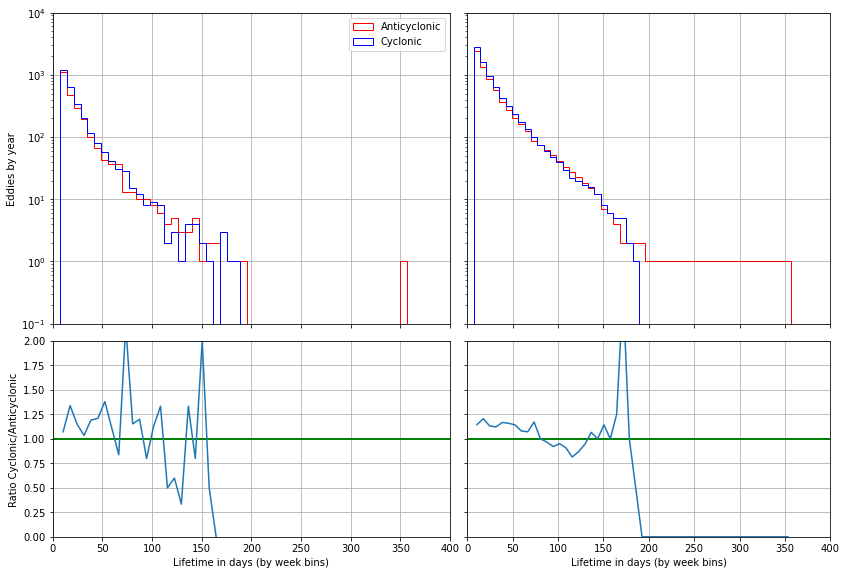

In [17]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_true_alg.nb_obs_by_track, c_true_alg.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

/work/ollie/tmp/ipykernel_33798/2539590205.py:33: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio_cum.plot(x, cum_c / cum_a)
/work/ollie/tmp/ipykernel_33798/2539590205.py:34: RuntimeWarning: divide by zero encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)
/work/ollie/tmp/ipykernel_33798/2539590205.py:34: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)


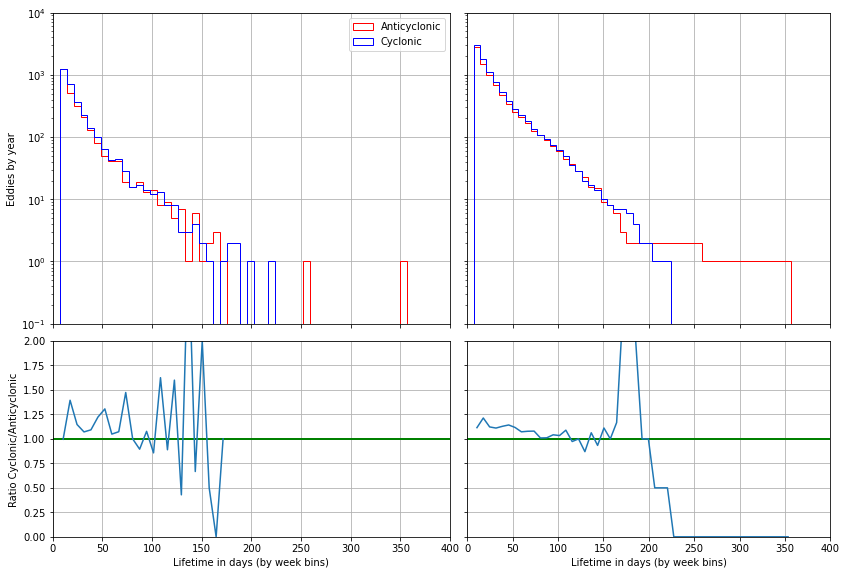

In [18]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_true.nb_obs_by_track, c_true.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

/work/ollie/tmp/ipykernel_33798/2652726430.py:33: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio_cum.plot(x, cum_c / cum_a)
/work/ollie/tmp/ipykernel_33798/2652726430.py:34: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)


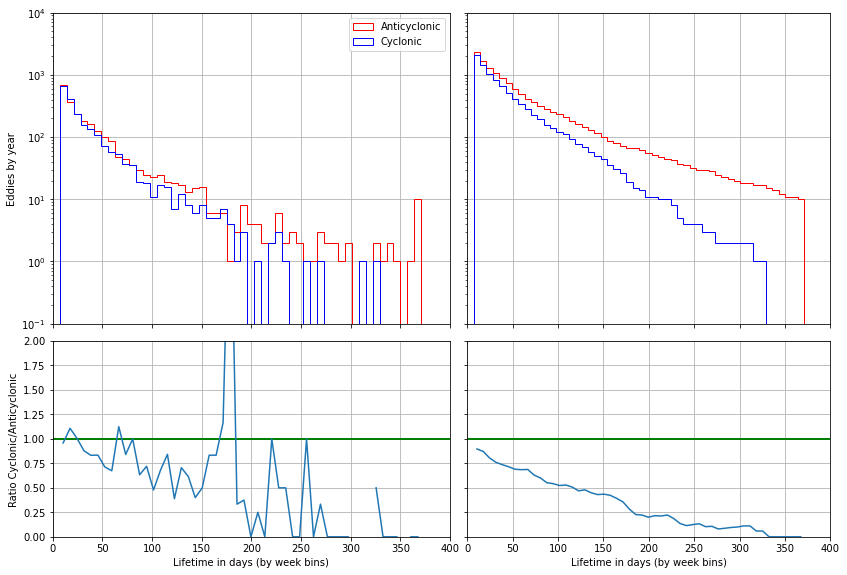

In [19]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_pred.nb_obs_by_track, c_pred.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

# Norm Eddy Lifetime

In [20]:
def sum_profile(x_new, y, out):
    """Will sum all interpolated given array"""
    out += interp(x_new, linspace(0, 1, y.size), y)


class MyObs(TrackEddiesObservations):
    def eddy_norm_lifetime(self, name, nb, factor=1):
        """
        :param str,array name: Array or field name
        :param int nb: size of output array
        """
        y = self.parse_varname(name)
        x = linspace(0, 1, nb)
        out = zeros(nb, dtype=y.dtype)
        nb_track = 0
        for i, b0, b1 in self.iter_on("track"):
            y_ = y[i]
            size_ = y_.size
            if size_ == 0:
                continue
            sum_profile(x, y_, out)
            nb_track += 1
        return x, out / nb_track * factor

In [21]:
a_true

/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:302: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


| 70671 observations from 4018.0 to 4382.0 (365.0 days, ~194 obs/day)
    |   Speed area      : 1.46 Mkm²/day
    |   Effective area  : 1.98 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      28.00     20.32     12.45      8.31      6.16     13.44     11.33
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     20.63     34.72     20.85     13.00      8.32      2.47      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     15.69     30.17     20.02     14.26     12.08      7.76      0.01
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     47.51       nan       nan       nan
        Mean effective radius (km):        nan     54.91       nan       nan       nan
        Mean amplitude (cm)       :        nan      4.33       nan       nan       nan
    | 4784 tracks (14.77 obs/tracks, shorter 2 obs, longer 356 obs)
    |   9426 filled observations (1.97 obs/tracks, 13.34 % of total)
    |   Intepolated speed area      : 0.17 Mkm²/day
    |   Intepolated effective area  : 0.22 Mkm²/day
    |   Distance by day             : Mean 11.53 , Median 3.59 km/day
    |   Distance by track           : Mean 158.74 , Median 39.91 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :      87.40     11.04      1.53      0.02      0.02      0.00      0.00
    |   Percent of eddies         :      52.47     34.71     11.95      0.36      0.50      0.00      0.00

In [24]:
with Dataset("/home/ollie/ssunar/temp_dir/a_true_alg.nc", "w") as h:
    a_true_alg.to_netcdf(h)
with Dataset("/home/ollie/ssunar/temp_dir/c_true_alg.nc", "w") as h:
    c_true_alg.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_true_alg_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_true_alg.nc")
c_true_alg_myobs = MyObs.load_file("/home/ollie/ssunar/temp_dir/c_true_alg.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_true_alg_myobs.nb_obs_by_track.max()
nb_max_c = c_true_alg_myobs.nb_obs_by_track.max()

AC_radius_true_alg = a_true_alg_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_a, factor=1e-3)
CC_radius_true_alg = c_true_alg_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_true_alg = a_true_alg_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_true_alg = c_true_alg_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [22]:
with Dataset("/home/ollie/ssunar/temp_dir/a_true.nc", "w") as h:
    a_true.to_netcdf(h)
with Dataset("/home/ollie/ssunar/temp_dir/c_true.nc", "w") as h:
    c_true.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_true_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_true.nc")
c_true_myobs = MyObs.load_file("/home/ollie/ssunar/temp_dir/c_true.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_true_myobs.nb_obs_by_track.max()
nb_max_c = c_true_myobs.nb_obs_by_track.max()

AC_radius_true = a_true_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_a, factor=1e-3)
CC_radius_true = c_true_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_true = a_true_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_true = c_true_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [23]:
with Dataset("/home/ollie/ssunar/temp_dir/a_pred.nc", "w") as h:
    a_pred.to_netcdf(h)
with Dataset("/home/ollie/ssunar/temp_dir/c_pred.nc", "w") as h:
    c_pred.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_pred_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_pred.nc")
c_pred_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/c_pred.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_pred_myobs.nb_obs_by_track.max()
nb_max_c = c_pred_myobs.nb_obs_by_track.max()

AC_radius_pred = a_pred_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_a, factor=1e-3)
CC_radius_pred = c_pred_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_pred = a_pred_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_pred = c_pred_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [26]:
a_true_myobs

| 70671 observations from 4018.0 to 4382.0 (365.0 days, ~194 obs/day)
    |   Speed area      : 1.46 Mkm²/day
    |   Effective area  : 1.98 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      28.01     20.30     12.45      8.30      6.15     13.45     11.33
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     20.63     34.72     20.85     13.00      8.32      2.47      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     15.68     30.17     20.02     14.27     12.09      7.76      0.01
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     47.51       nan       nan       nan
        Mean effective radius (km):        nan     54.91       nan       nan       nan
        Mean amplitude (cm)       :        nan      4.33       nan       nan       nan
    | 4784 tracks (14.77 obs/tracks, shorter 2 obs, longer 356 obs)
    |   9426 filled observations (1.97 obs/tracks, 13.34 % of total)
    |   Intepolated speed area      : 0.17 Mkm²/day
    |   Intepolated effective area  : 0.22 Mkm²/day
    |   Distance by day             : Mean 11.53 , Median 3.59 km/day
    |   Distance by track           : Mean 158.74 , Median 39.91 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :      87.40     11.04      1.53      0.02      0.02      0.00      0.00
    |   Percent of eddies         :      52.47     34.71     11.95      0.36      0.50      0.00      0.00

(Text(0, 0.5, 'Amplitude (cm)'),
 None,
 <matplotlib.legend.Legend at 0x2aab97c672b0>)

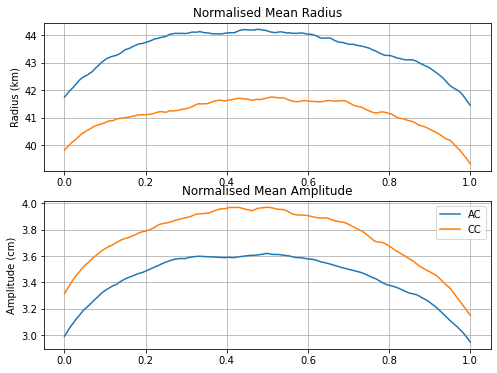

In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_true), ax0.plot(*CC_radius_true)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_true, label="AC"), ax1.plot(*CC_amplitude_true, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

(Text(0, 0.5, 'Amplitude (cm)'),
 None,
 <matplotlib.legend.Legend at 0x2aabb5a0b820>)

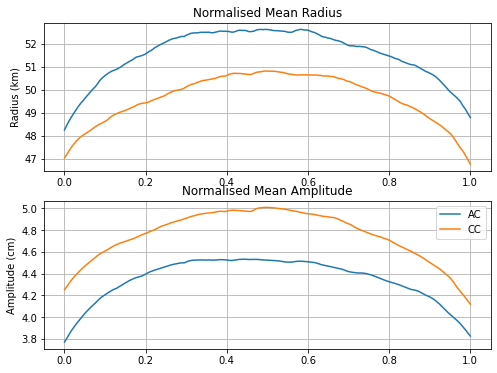

In [29]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_true_alg), ax0.plot(*CC_radius_true_alg)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_true_alg, label="AC"), ax1.plot(*CC_amplitude_true_alg, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

(Text(0, 0.5, 'Amplitude (cm)'),
 None,
 <matplotlib.legend.Legend at 0x2aabb5932760>)

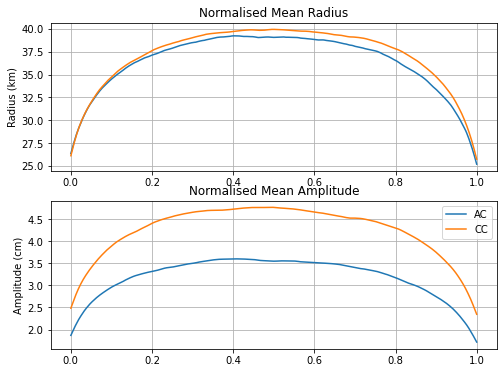

In [28]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_pred), ax0.plot(*CC_radius_pred)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_pred, label="AC"), ax1.plot(*CC_amplitude_pred, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

In [ ]:
# Correspondance class = Track observations
# TrackEddyObservation class = Child class of EddyObservation which has extra attributes of tracking

# EddyObservation -> Correspondance -> TrackEddyObservation

In [ ]:
#why nb conflict for cyclonic eddies
#fix the longitude 
#fix the GUI display type Done
#store in same longitude format
# R- Produce one year of data

In [ ]:
# Fix the true observation data latitude


In [43]:
temp_eddy = a_true.extract_ids([0]).index(slice(0, 6))

In [51]:
np.argwhere(a_true.time == 0.0)

array([[  33],
       [  42],
       [  48],
       [  90],
       [  94],
       [  95],
       [  96],
       [ 107],
       [ 108],
       [ 141],
       [ 146],
       [ 162],
       [ 163],
       [ 166],
       [ 192],
       [ 193],
       [ 194],
       [ 256],
       [ 265],
       [ 266],
       [ 267],
       [ 306],
       [ 347],
       [ 348],
       [ 350],
       [ 355],
       [ 358],
       [ 360],
       [ 363],
       [ 367],
       [ 368],
       [ 375],
       [ 382],
       [ 385],
       [ 410],
       [ 428],
       [ 432],
       [ 435],
       [ 441],
       [ 447],
       [ 482],
       [ 484],
       [ 486],
       [ 488],
       [ 490],
       [ 494],
       [ 496],
       [ 497],
       [ 499],
       [ 500],
       [ 501],
       [ 521],
       [ 522],
       [ 523],
       [ 544],
       [ 545],
       [ 546],
       [ 558],
       [ 559],
       [ 568],
       [ 569],
       [ 570],
       [ 574],
       [ 577],
       [ 579],
       [ 580],
       [ 5

<IPython.core.display.Javascript object>


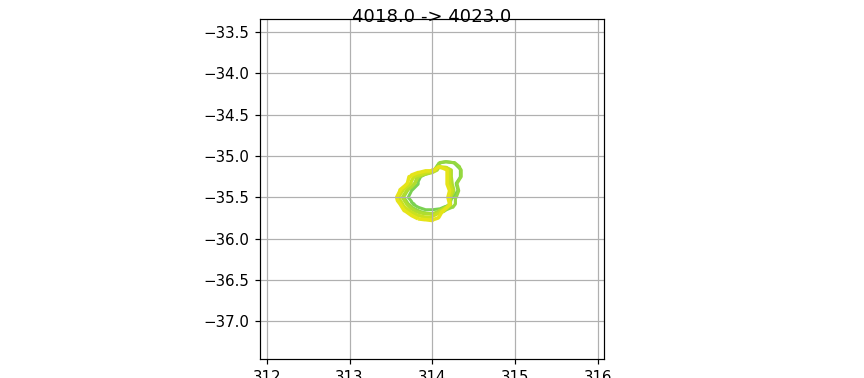

In [44]:
%matplotlib notebook
a = Anim(temp_eddy, sleep_event=0.1, intern=False, figsize=(8, 3.5), cmap="viridis")
a.txt.set_position((-26, -43))
a.show(infinity_loop=False)

<IPython.core.display.Javascript object>


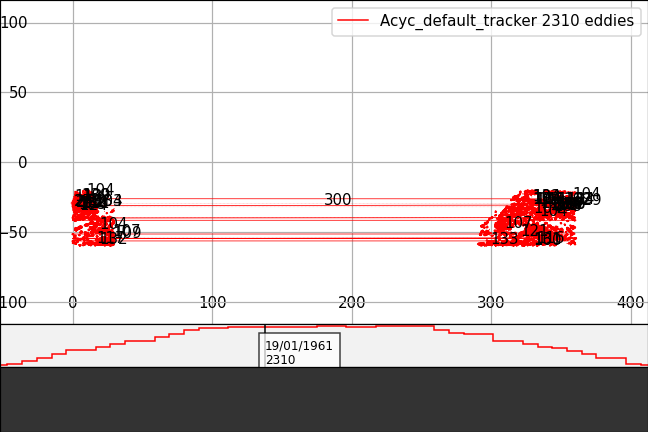

In [69]:
g = GUI(Acyc_default_tracker=eddies_default_tracker)
g.now = 4018
g.bbox = 0, 360, -90, 90
g.adjust()
g.show()

In [103]:
g.now

4018

In [ ]:
# GUI centered at the region we want
# Statistic 



In [ ]:
# Use the whole process for true segmentation data and compare with the original one.
# 